## Table of Contents:
* [**Section 1**: Introduction, data analysis and visualization of the CitiBike Dataset](#ref1)
* [**Section 2**: Prediction Challenge](#ref2)
* [**Section 3**: Exploratory analysis](#ref3)
* [**Section 4**: Conclusion](#ref4)

In [14]:
from utils_appendix import data_preparation, create_plots, load_bikeshare_frames, pca, tune_hyperparameters, train_model
from importlib import reload
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import optuna, plotly
from sklearn import tree, neighbors ,ensemble, metrics, model_selection, linear_model
np.random.seed(9)
pd.set_option("display.notebook_repr_html", False)

## Members
Michael,
Clara, 
Louis, 
Alvaro

## Contributions Table:
Section 1 : Michael did the data formating, Louis did the plotting and Clara did the data description. 
Section 2 : Michael did the hyper parametrization and Clara and Louis did the reporting. 
Section 3 : Alvaro did the PCA, Michael did the model we based it on and Clara and Louis did the report and the problematization. 
Section 4 : Michael, Clara and Louis. 

Alvaro, Louis and Clara contributed equaly to this project. Michael invested a lot of time in the training and hyper parameter tuning part of the project and should have a special mention. 


# Section 1: Introduction, data analysis and visualization of the CitiBike Dataset <a id="ref1"></a>

## Project introduction

In this project an analysis will be conducted on citybikes in NY, more specifically on the amount
of pickups per hour. To conduct this analysis, datasets with all the registered pickups are given
together with type of user, start and end time of the trip and the start and end location. In the
prediction challenge only this data will be used to predict the number of pickups in the future.
In the explanatory analysis, extra datesets will be added in order to explore if the weather and
sun angle predictions can allow to obtain more accurate models and therefore if it is worth for the
company to invest in forecasting. 

## Loading and preprocessing the dataset:

Datasets containing information about the weather, sun angle, weekends and holidays have been
added to the dateset. In the following graphics their influence will be graphically shown.

In [2]:
csvs = load_bikeshare_frames.list_working_csvs()
full_df = data_preparation.prep(csvs)

listed paths to 76 csvs
attemp loading 76 csvs on 12 cpu processes


## Visualization : plot generation

16


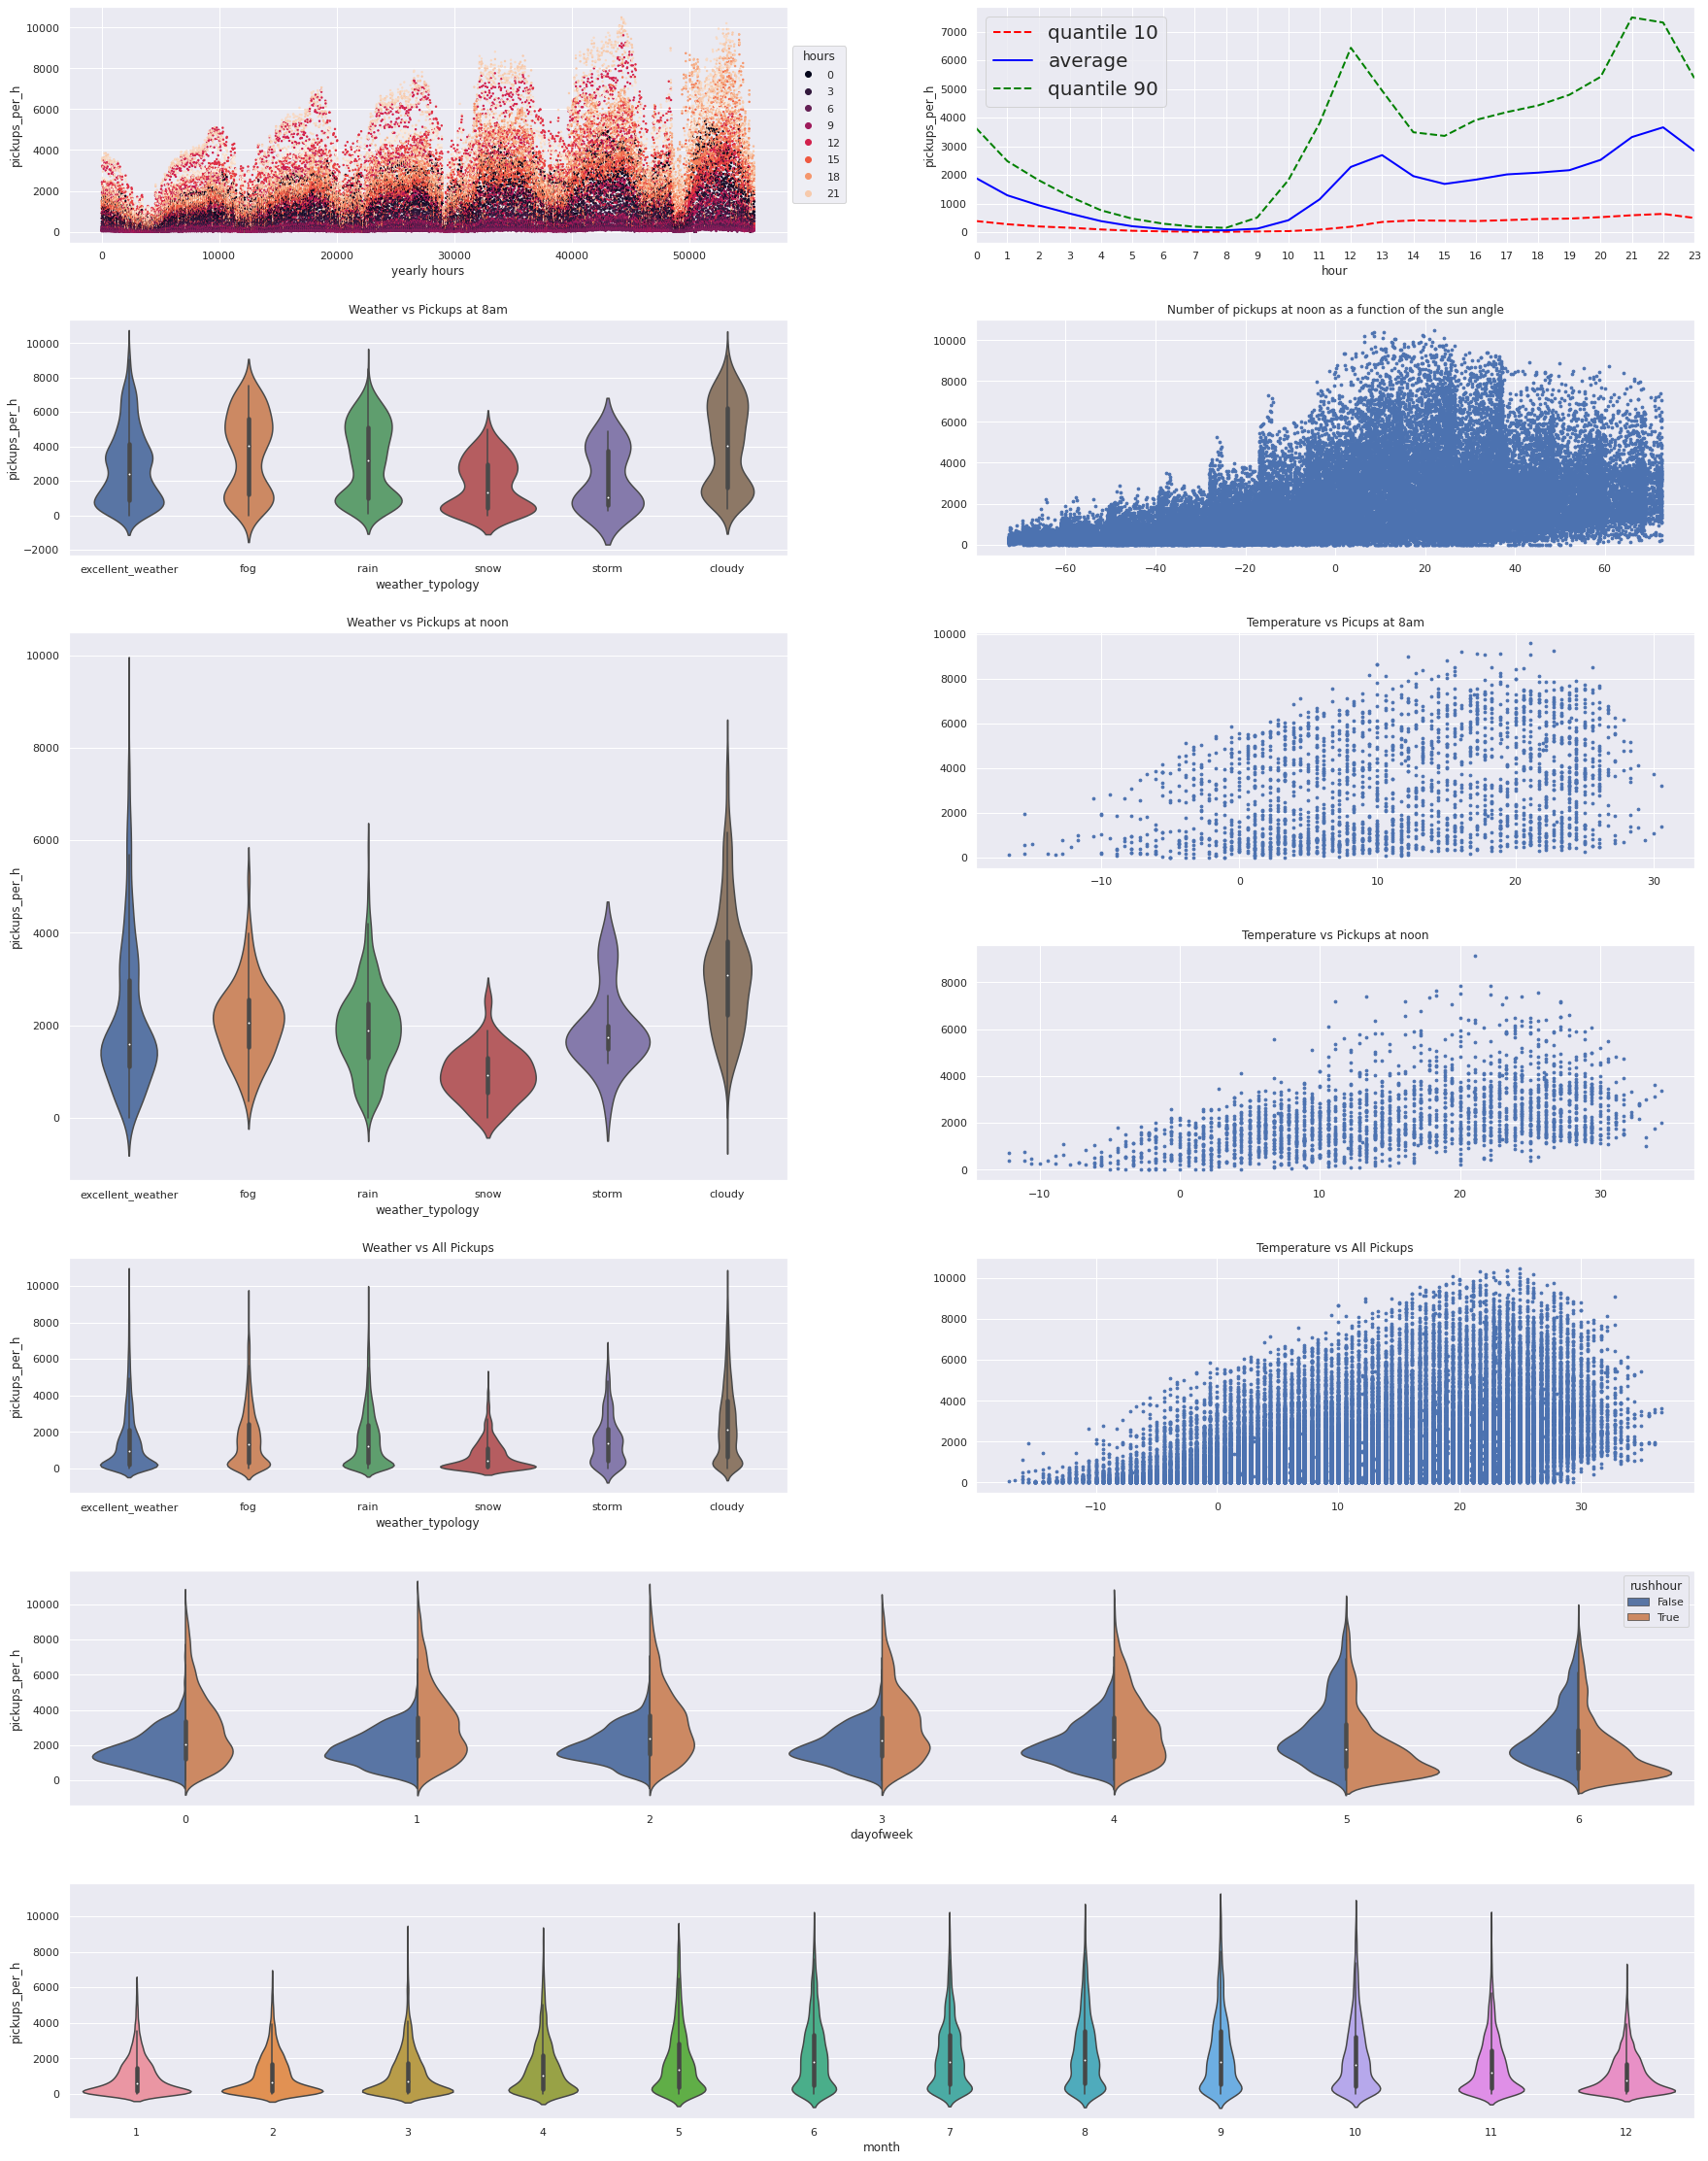

In [3]:
create_plots.plots(full_df)

## Plot Analysis

**Left column of graphics :**

* In the first graphic we can see that the **pickups are periodical throughout the years** and the consumption has increased.
* Regarding the weather typology we can see a **decrease on pickups when it snows and storms**. Furthermore, the distribution patterns can differ from one hour to another.
* The bike use **pattern in the weekdays and weekends is different** : we can see an increase of rushhours in the weekends. For holidays the same influence would be expected.
* The pickup average evolves between the yearly seasons with a **higher pickup volume in the warm periods** like summer and spring.


**Right column of graphics :**

* In the quantile per hour graphic we can see the evolution of the pickups through the day with **two peaks** at midday and in the evening.
* The **temperature has an influence on the amount of pickups** (see 3 blue scatterplots in the right side showing the pickups in function of temperature at different hours of the day). If the temperature is low or very high there are less pickups than when the temperature is normal.
* We can also notice the influence of the sun angle. When the sun is down, the amount of pickups drop drastically. We can interpret that **users don’t like to use the citibikes when it is dark**.

# Section 2: Prediction challenge <a id="ref2"></a>

Lets take a look at the data. To make some good predictions all the data from 2014 to 2020 will be used to train, validate and test our models. This data set contains 100 million lines. Adding the distance of a trip as an extra variable can be useful, consequently, we added an extra column with the distance per trip.
The target variable is the amount of trips per hour. So the data has to be modified to take this feature into account. The  modified df will therefore contain the number of pickups per hour and the averages of the other parameters. In addition, the number of woman, men and unknown will be counted. 

## Prediction challenge PART 1: Training model for 1 week given 2 months of data

### Data set explanation : 
We used the training data from september to november 2017 and decided to keep the following features : day of the week, day of the year, cosinus and sinus of day of the year and cosinus and sinus of minute of the day. The reason we chose this specific features is in other to **manipulate continuous variables for the models**, specially from one day to another and one year to another. <br>

In [4]:
val_set_series_2w = full_df.pickups_per_h.loc[pd.date_range(start="2017-10-01 02:00:00", end="2017-10-09 03:00:00", freq="H", tz="US/Eastern")]
train_set_series_2w = full_df.pickups_per_h.loc[pd.date_range(start="2017-10-09 04:00:00", end="2017-11-30 04:00:00", freq="H", tz="US/Eastern")]
test_set_series_2w = full_df.pickups_per_h.loc[pd.date_range(start="2017-11-30 05:00:00", end="2017-12-08 05:00:00", freq="H", tz="US/Eastern")]

#import the selected features
FP = train_model.ForwardPredicter(duration_rows_past = 12, duration_forecast=3, 
    columns_past_features = tune_hyperparameters.DATEONLY_COLUMNS,  
    sideline_fut_features = [],)

# preprocess data from train series on ForwardPredicter|
X_work, X_unscaled, y_work = FP.create_x_y_work(
    train_series = val_set_series_2w.append(train_set_series_2w), hours_between_samples=1)
# get X_val at beginning of period
X_val, X_train, y_val,  y_train= model_selection.train_test_split(X_work, y_work, shuffle=False, test_size=0.85)
f"using information in forecasting {tune_hyperparameters.DATEONLY_COLUMNS}"

columns_past_features: ['pickups_per_h', 'feat_minuteofday_cos', 'feat_dayoftheyear_sin', 'feat_dayoftheyear_cos', 'feat_minuteofday_sin', 'feat_dayoftheweek']. columns_past_features: ['pickups_per_h', 'feat_minuteofday_cos', 'feat_dayoftheyear_sin', 'feat_dayoftheyear_cos', 'feat_minuteofday_sin', 'feat_dayoftheweek']


Train samples: 100%|██████████| 1429/1429 [00:00<00:00, 9051.73it/s]

shape of X is (1429, 72), y (1429, 3)


"using information in forecasting ['feat_dayoftheweek', 'feat_dayoftheyear_sin', 'feat_dayoftheyear_cos', 'feat_minuteofday_sin', 'feat_minuteofday_cos']"

In [5]:
# get X_test DecisionTreeRegressoroad them with
X_test_frame = FP.get_frame_for_predict(
    previous_pickups = train_set_series_2w[-FP.duration_rows_past:], 
    predict_hours = 7 * 24 )
y_test_true = test_set_series_2w[:7 * 24]
X_test_frame.head(FP.duration_rows_past + 2) # show df with first 2 NaNs in pickups_per_h

                           pickups_per_h  feat_minuteofday_cos  \
2017-11-29 22:00:00+00:00         5083.0         -2.588190e-01   
2017-11-29 23:00:00+00:00         5251.0         -1.836970e-16   
2017-11-30 00:00:00+00:00         3543.0          2.588190e-01   
2017-11-30 01:00:00+00:00         2265.0          5.000000e-01   
2017-11-30 02:00:00+00:00         1559.0          7.071068e-01   
2017-11-30 03:00:00+00:00         1130.0          8.660254e-01   
2017-11-30 04:00:00+00:00          638.0          9.659258e-01   
2017-11-30 05:00:00+00:00          275.0          1.000000e+00   
2017-11-30 06:00:00+00:00          116.0          9.659258e-01   
2017-11-30 07:00:00+00:00           57.0          8.660254e-01   
2017-11-30 08:00:00+00:00           33.0          7.071068e-01   
2017-11-30 09:00:00+00:00           73.0          5.000000e-01   
2017-11-30 10:00:00+00:00            NaN          2.588190e-01   
2017-11-30 11:00:00+00:00            NaN          6.123234e-17   

         

### Explanation of the model : 
Each predicted set will use the **previous 12 hours** of available data and will be composed of values that predict **3 hours** of data. It is important to understand that future **predictions recurrently built upon already predicted data**. 
<br>
We want to point out that we used some of the models we learned in the course in this part, such as *sklearn.tree.DecisionTreeRegressor*.

Forecast of 3h steps, to reach 168: 100%|██████████| 56/56 [00:00<00:00, 2518.80it/s]


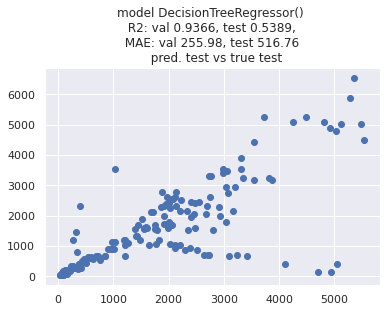

Forecast of 3h steps, to reach 168: 100%|██████████| 56/56 [00:00<00:00, 2490.05it/s]


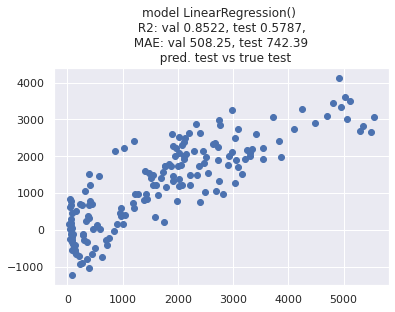

Forecast of 3h steps, to reach 168: 100%|██████████| 56/56 [00:00<00:00, 1678.80it/s]


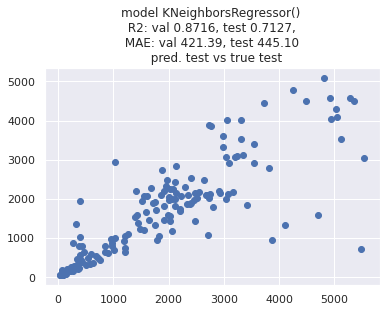

Forecast of 3h steps, to reach 168: 100%|██████████| 56/56 [00:00<00:00, 240.23it/s]


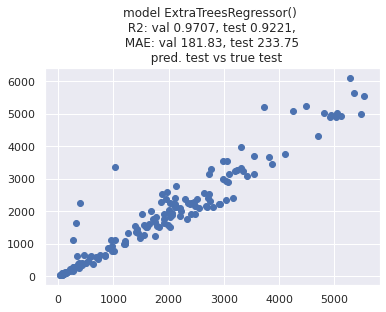

In [6]:
np.random.seed(9)
for model in [tree.DecisionTreeRegressor(), linear_model.LinearRegression(), neighbors.KNeighborsRegressor(), ensemble.ExtraTreesRegressor()]: 
    model.fit(X_train, y_train)
    r2_val = model.score(X_val, y_val)
    # test
    y_pred_test, _ = FP.repeat_predict_unknown_frame_forward(X_test_frame.copy(), model, 7 * 24)
    r2_test = metrics.r2_score(y_test_true, y_pred_test)
    mae_val =  metrics.mean_absolute_error(y_val, model.predict(X_val))
    mae_test =  metrics.mean_absolute_error(y_test_true, y_pred_test)
    # output
    plt.scatter(y_test_true, y_pred_test )
    plt.title(f"model {model} \n R2: val {r2_val:.4f}, test {r2_test:.4f}, \n MAE: val {mae_val:.2f}, test {mae_test:.2f} \n  pred. test vs true test");
    plt.show()

The graphics above show the predicted value as a function of the real value, therefore with optimal performance this shound be **near linear**. We also evaluate the **Mean Average Error** and **R-square** on both test and validation set.

In order to obtain optimal results we decided to test **multiple configurations with the hyper-parameter tuning** and keep the one with the best performances based on the validation set. We tune several parameters such as input columns, regression model and scaler for 100 trials.

starting hyperparameter optimization with 100 trials 
using series for train starttime
2017-10-09 08:00:00+00:00     80.0
2017-10-09 09:00:00+00:00    210.0
Freq: H, Name: pickups_per_h, dtype: float64
,measureing performance by predicting test/val for duration of 168
tuning the columns_past_features ['feat_dayoftheweek', 'feat_dayoftheyear_sin', 'feat_dayoftheyear_cos', 'feat_minuteofday_sin', 'feat_minuteofday_cos']
tuning the sideline_fut_features ['feat_dayoftheweek', 'feat_dayoftheyear_sin', 'feat_dayoftheyear_cos', 'feat_minuteofday_sin', 'feat_minuteofday_cos']
tunes the int duration_rows_past {'low': 1, 'high': 24}
tunes the int duration_forecast {'low': 1, 'high': 24}

==================== hyperparameter optimaization with 100 trials is done ==================== 

	 best trial has params:
use_past_feat_dayoftheweek: True
use_past_feat_dayoftheyear_sin: True
use_past_feat_dayoftheyear_cos: False
use_past_feat_minuteofday_sin: False
use_past_feat_minuteofday_cos: True
use_future

/home/beast-michi/Desktop/ds_mobility/Project/utils_appendix/tune_hyperparameters.py:187: ExperimentalWarning:

plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.



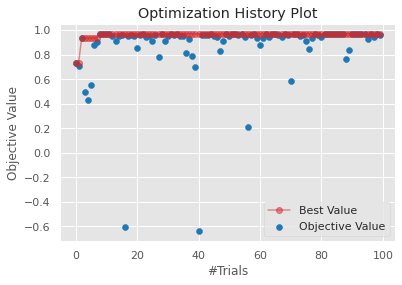

In [7]:
study_regular2w = tune_hyperparameters.tune(
     train_series = train_set_series_2w, val_series = val_set_series_2w, test_series= test_set_series_2w, 
     tune_columns_past_features = tune_hyperparameters.DATEONLY_COLUMNS,
     tune_sideline_fut_features = tune_hyperparameters.DATEONLY_COLUMNS,
     n_predict_hours=24*7,
)

### Choice of predictive model and outcome : 
We decided to keep a models based on the validation R square results, i.e. approx 0.96. The best performing model with an **R square of approximatiely 0.92 for the test set** is an ensemble using *sklearn.ensemble.RandomForestRegressor()* and StandardScaler. It predicts the next 7h of pickups given the last 16h. All columns get used.

## Prediction challenge PART 2: Training model for 2 months given 10 months of data

For this part, we selected the same variables to train our model and used the training data from January to November 2017. <br>
The ForwardPredicter function is used to test again all of the predictive models used for the first part of the prediction challenge. The difference between the two parts will be the amount of previous data we use to predict and the number of hours predicted at a time.

starting hyperparameter optimization with 100 trials 
using series for train starttime
2017-03-01 09:00:00+00:00     59.0
2017-03-01 10:00:00+00:00    317.0
Freq: H, Name: pickups_per_h, dtype: float64
,measureing performance by predicting test/val for duration of 1344
tuning the columns_past_features ['feat_dayoftheweek', 'feat_dayoftheyear_sin', 'feat_dayoftheyear_cos', 'feat_minuteofday_sin', 'feat_minuteofday_cos']
tuning the sideline_fut_features ['feat_dayoftheweek', 'feat_dayoftheyear_sin', 'feat_dayoftheyear_cos', 'feat_minuteofday_sin', 'feat_minuteofday_cos']
tunes the int duration_rows_past {'low': 1, 'high': 24}
tunes the int duration_forecast {'low': 1, 'high': 24}

==================== hyperparameter optimaization with 100 trials is done ==================== 

	 best trial has params:
use_past_feat_dayoftheweek: True
use_past_feat_dayoftheyear_sin: False
use_past_feat_dayoftheyear_cos: True
use_past_feat_minuteofday_sin: False
use_past_feat_minuteofday_cos: True
use_futur

/home/beast-michi/Desktop/ds_mobility/Project/utils_appendix/tune_hyperparameters.py:187: ExperimentalWarning:

plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.



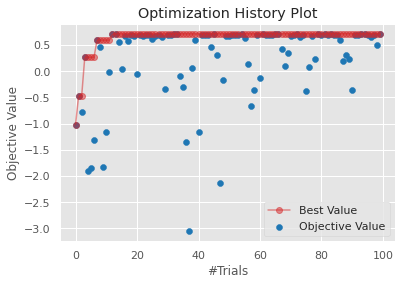

In [8]:
val_set_series_10m = full_df.pickups_per_h.loc[pd.date_range(start="2017-01-01 03:00:00", end="2017-03-01 03:00:00", freq="H", tz="US/Eastern")]
train_set_series_10m = full_df.pickups_per_h.loc[pd.date_range(start="2017-03-01 04:00:00", end="2017-10-31 04:00:00", freq="H", tz="US/Eastern")]
test_set_series_10m = full_df.pickups_per_h.loc[pd.date_range(start="2017-10-31 05:00:00", end="2017-12-31 06:00:00", freq="H", tz="US/Eastern")]

study_regular10m = tune_hyperparameters.tune(
     train_series = train_set_series_10m, val_series = val_set_series_10m, test_series= test_set_series_10m, 
     tune_columns_past_features = tune_hyperparameters.DATEONLY_COLUMNS,
     tune_sideline_fut_features = tune_hyperparameters.DATEONLY_COLUMNS,
     n_predict_hours=24*7*8,
)

/tmp/ipykernel_23258/3514575386.py:1: ExperimentalWarning:

plot_contour is experimental (supported from v2.2.0). The interface can change in the future.

[W 2021-11-28 23:50:47,711] Output figures of this Matplotlib-based `plot_contour` function would be different from those of the Plotly-based `plot_contour`.


<AxesSubplot:title={'center':'Contour Plot'}, xlabel='duration_rows_past', ylabel='duration_forecast'>

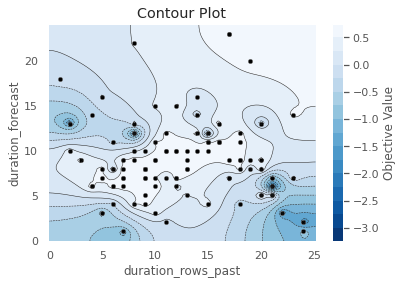

In [9]:
optuna.visualization.matplotlib.plot_contour(study_regular10m ,params=['duration_rows_past', 'duration_forecast'])

### Choice of predictive model and outcome : 
In this part of the project, the objective is to reach an R square of 0.3 for the test set. The best performing model was selected on the validation score with an **R square of approximatiely 0.67 the testing set** is the **ensemble.ExtraTreesRegressor()**. It performs forecasting using 1h of prior input to forecast 9h. As an insight into the hyperparameter tuning, the **optimal area for forecasting is around 6 to 10h, given the past 6 to 16 rows**.

# Section 3: Exploratory analysis  <a id="ref3"></a>

## Introduction
In this part, we will consider seasonal aspects like weather and sun angle, combined with weekly information such as day of the week and vacations in onder to determine if **seasonal trends** allow us to predict the data more accuratly. Therefore, the additional data we will use is : **weather condition, temperature, sun angle, date and national holiday.**
This question can be interesting for a rental bike company in order to know **if they should invest in having more accurate forecasting** in order to achieve better predictions. 
Note : In this part we took the historic recorded weather data, which yields a 100% accuracy and is therefore superior to any historic forecast. 

## Data set explanation : 
We decided to keep all of the date and time features since it is information that is always available (and that is free for a company). Before adding the complementary data for the dataset we **will perform a PCA in order to keep the most relevant features**.

## PCA on complementary features :

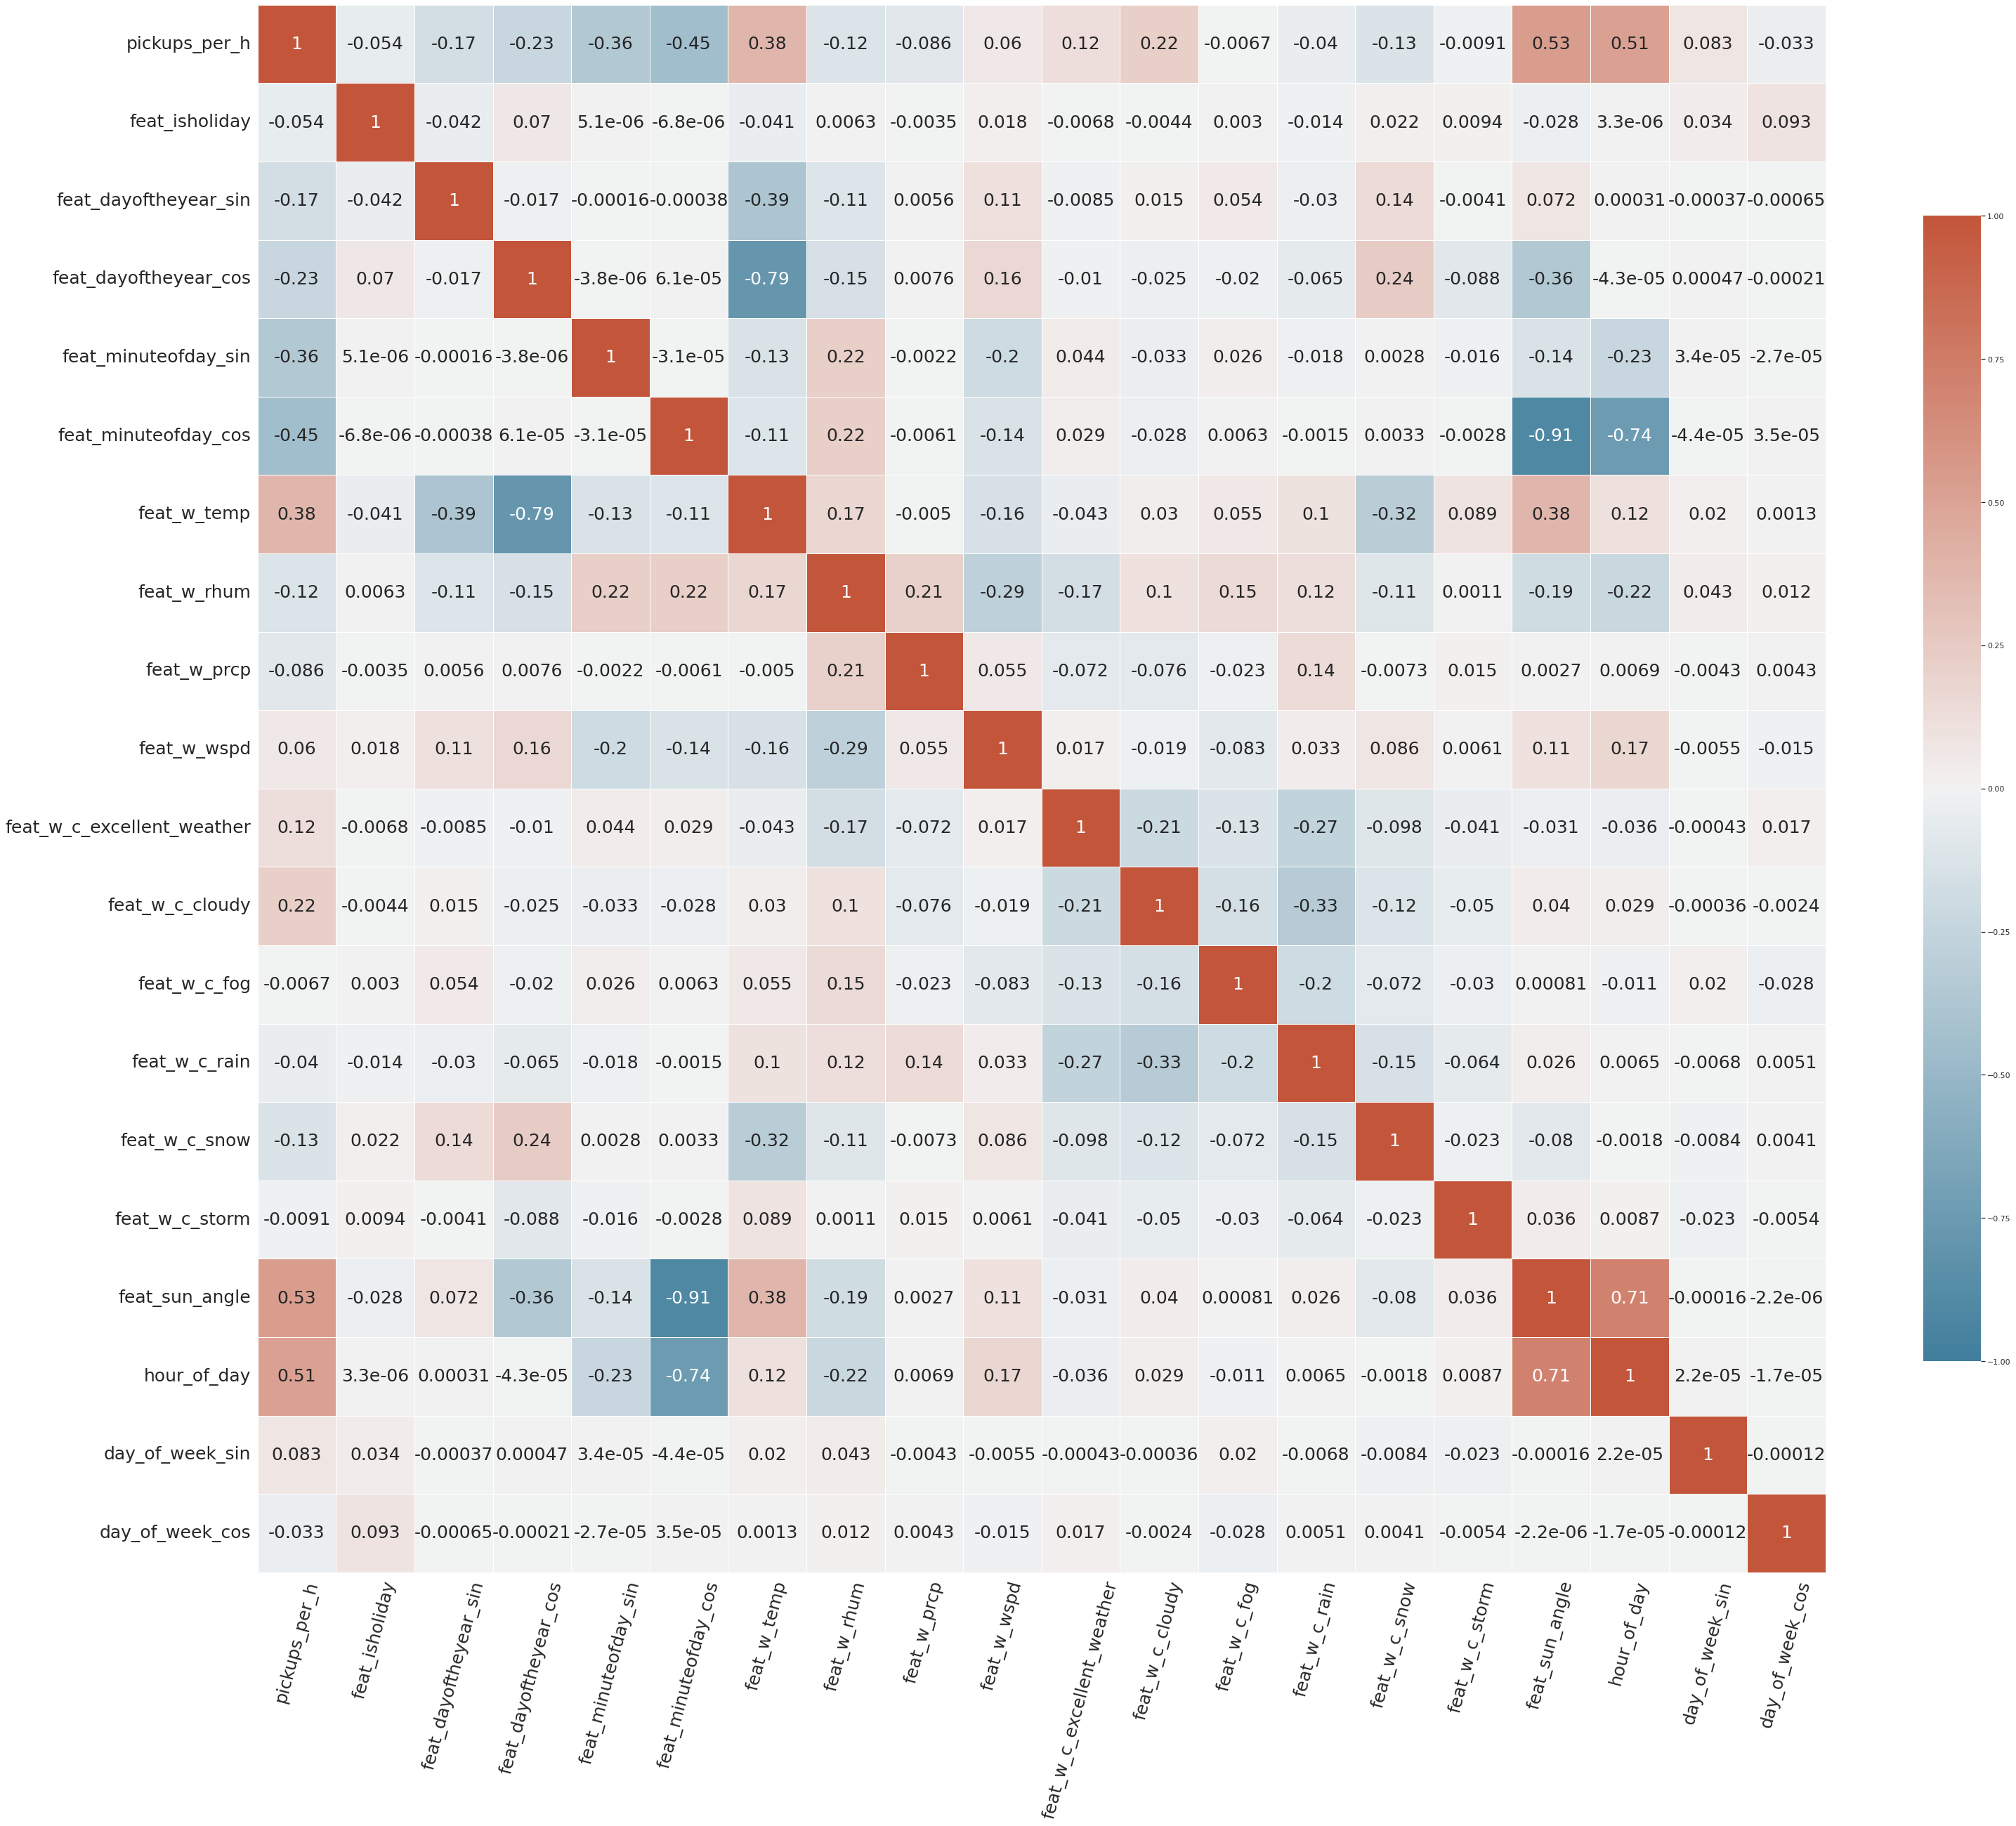

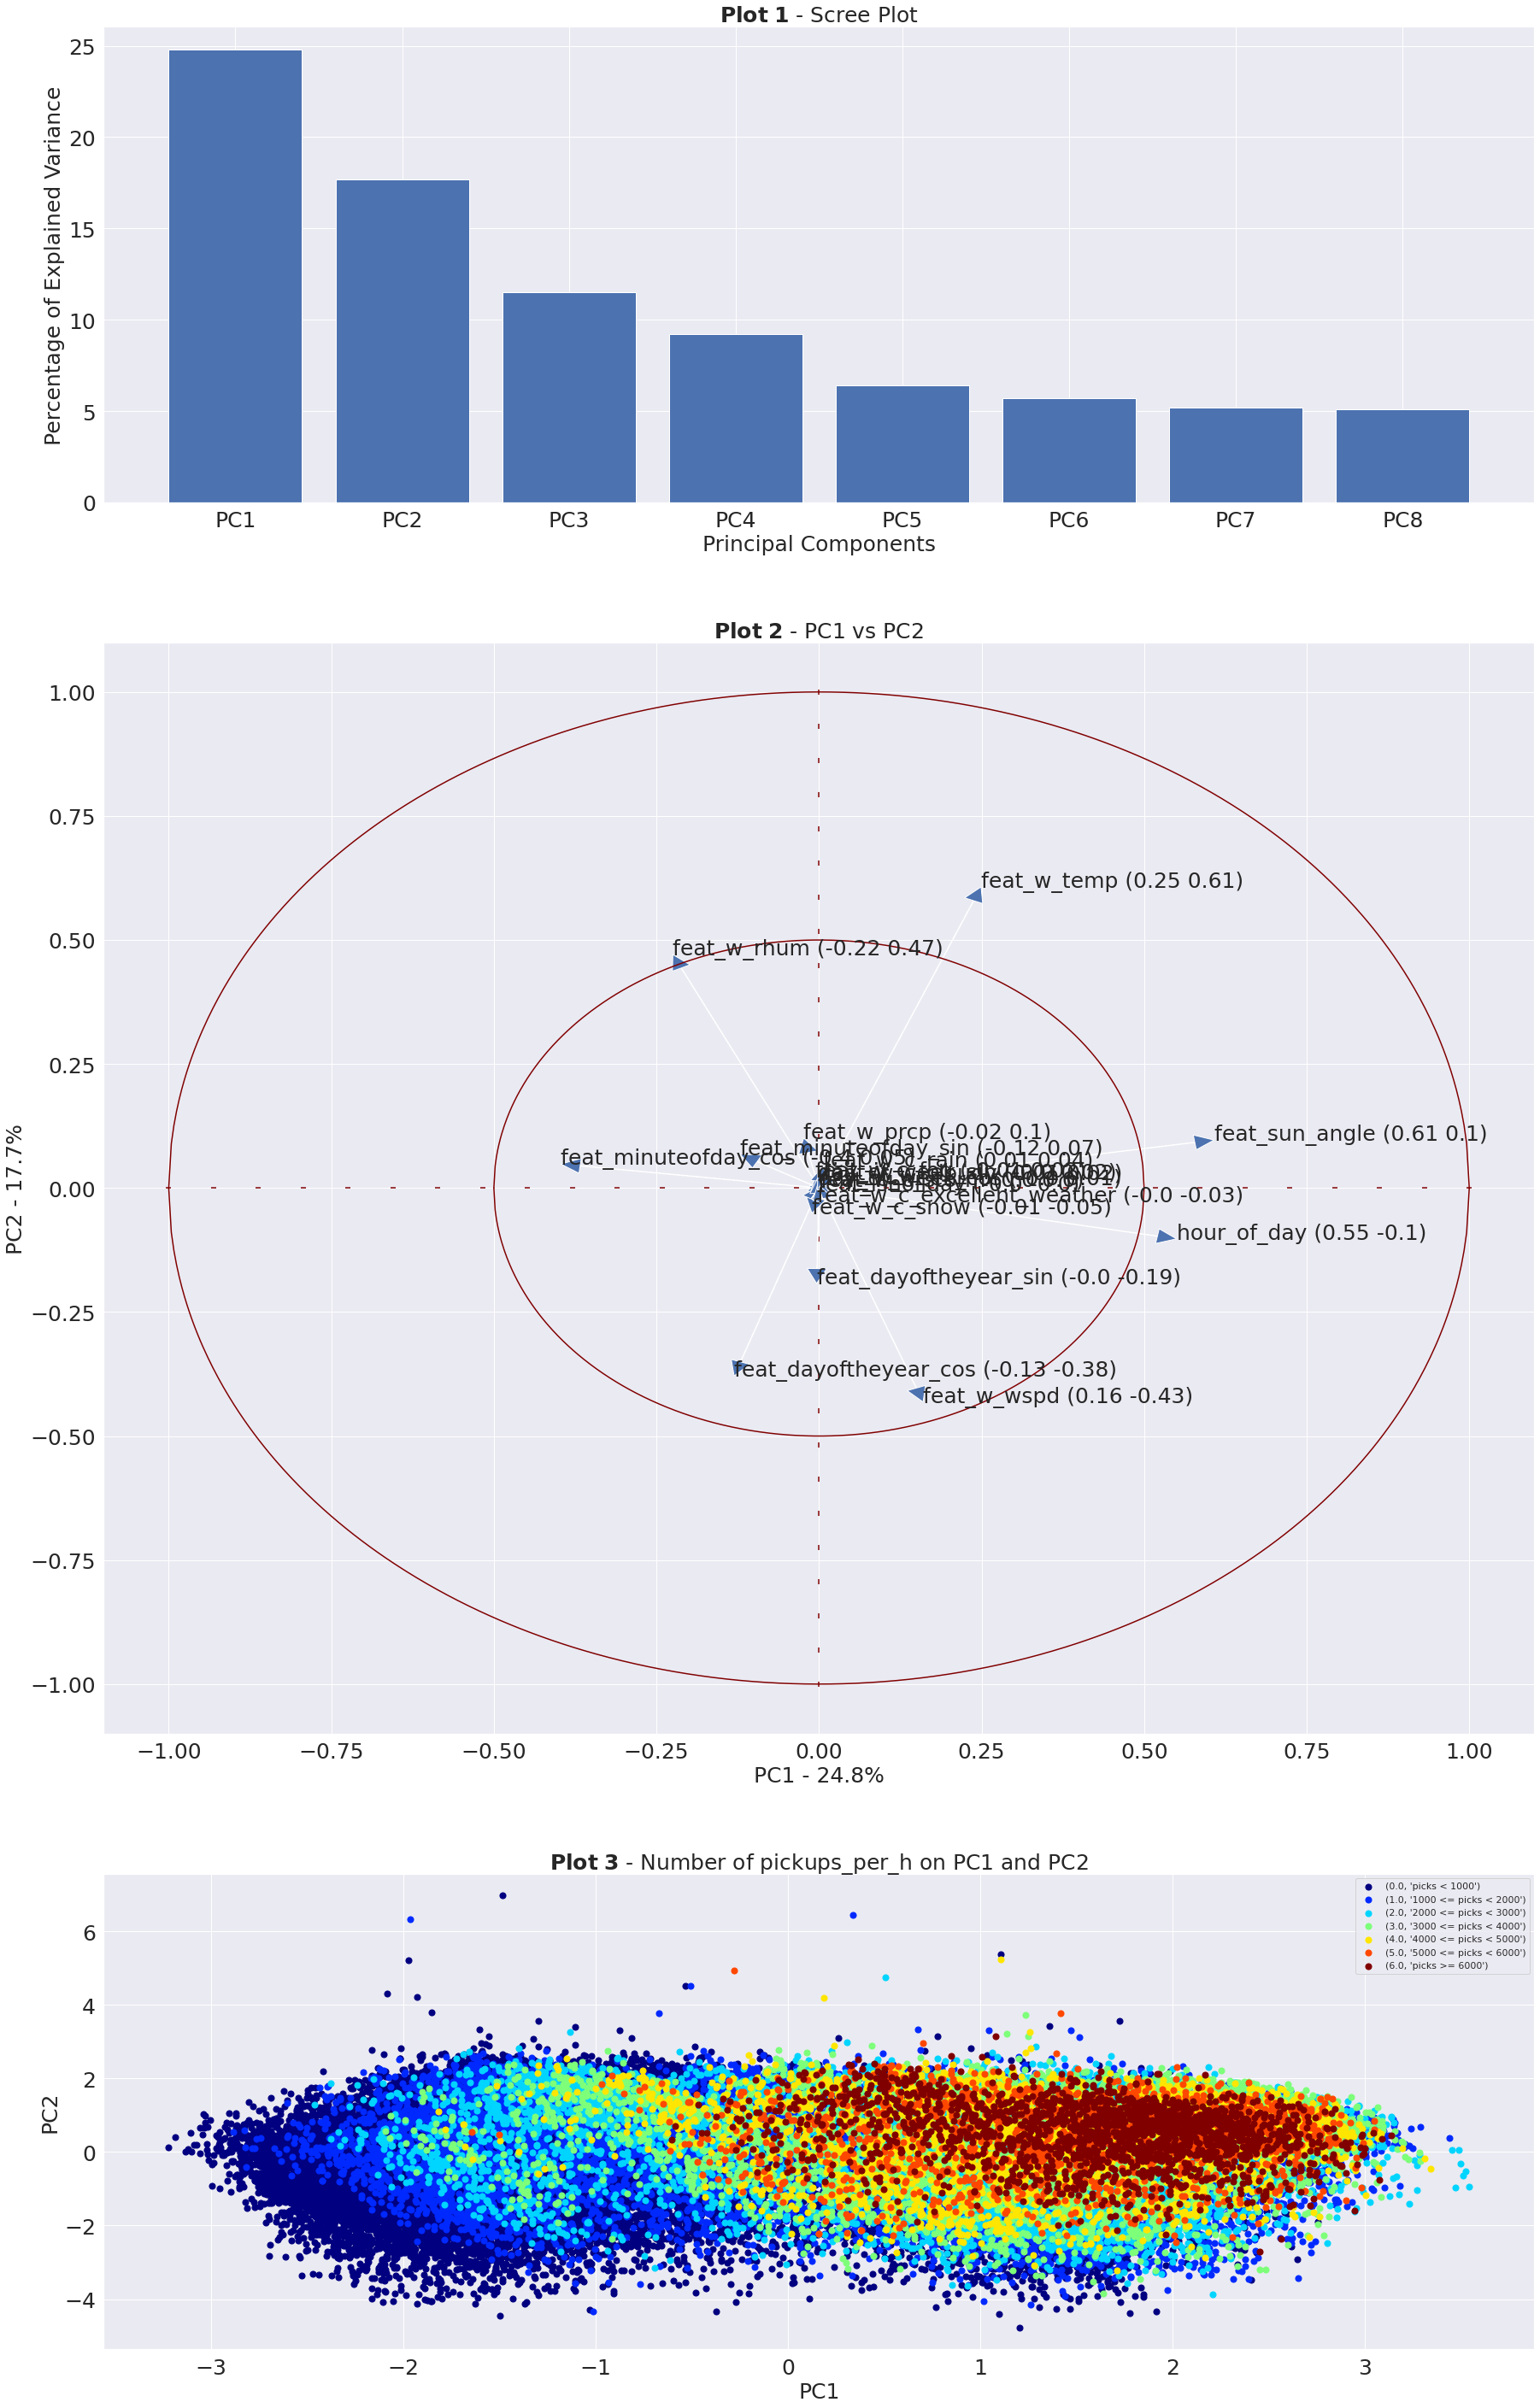

In [15]:
# Correlation Matric
data = pca.correlationMatrix(full_df)
s = pca.PCAnalysis(data)

When we look at the matrix (plot 1), we can notice that the temperature, the sun angle, the cosinus transform of the day of the year, the cosinus transform of the minute of the day, percipitation, wind speed and the humidity rate have the highest correlation with the pickups. When plotted over the first two principal components (over 45% of the explained variance) we can see that this features are evenly distributed in space of the loading plot (plot 2) and will **help to explain the variation on the pickups** (plot 3). Performing a PCA helped us **understand which additional features where valuable to add to our model**.

## Testing the additional data on our models

We used the same method as in the prediction challenge part 2 in this section, using 10 months of data to predict 2 months. 

starting hyperparameter optimization with 100 trials 
using series for train starttime
2017-10-09 08:00:00+00:00     80.0
2017-10-09 09:00:00+00:00    210.0
Freq: H, Name: pickups_per_h, dtype: float64
,measureing performance by predicting test/val for duration of 168
tuning the columns_past_features ['feat_dayoftheweek', 'feat_dayoftheyear_sin', 'feat_dayoftheyear_cos', 'feat_minuteofday_sin', 'feat_minuteofday_cos', 'feat_isholiday', 'feat_sun_angle']
tuning the sideline_fut_features ['feat_dayoftheweek', 'feat_dayoftheyear_sin', 'feat_dayoftheyear_cos', 'feat_minuteofday_sin', 'feat_minuteofday_cos', 'feat_isholiday', 'feat_sun_angle', 'feat_dayoftheweek', 'feat_dayoftheyear_sin', 'feat_dayoftheyear_cos', 'feat_minuteofday_sin', 'feat_minuteofday_cos', 'feat_isholiday', 'feat_sun_angle', 'feat_w_temp', 'feat_w_rhum', 'feat_w_prcp', 'feat_w_wspd', 'feat_w_c_excellent_weather', 'feat_w_c_cloudy', 'feat_w_c_fog', 'feat_w_c_rain', 'feat_w_c_snow', 'feat_w_c_storm']
tunes the int duratio

/home/beast-michi/Desktop/ds_mobility/Project/utils_appendix/tune_hyperparameters.py:187: ExperimentalWarning:

plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.



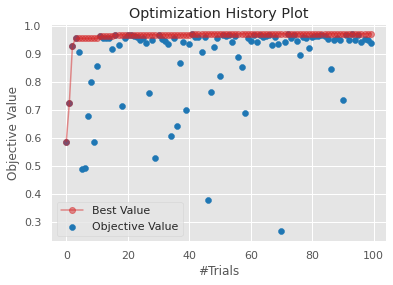

In [11]:
study_weather = tune_hyperparameters.tune(
     train_series = train_set_series_2w, val_series = val_set_series_2w, test_series= test_set_series_2w,  
     tune_columns_past_features = tune_hyperparameters.PERMISSIBLE_COLUMNS,
     tune_sideline_fut_features = tune_hyperparameters.PERMISSIBLE_COLUMNS + tune_hyperparameters.WEATHER_COLUMNS,
     n_predict_hours=24*7,
)

## Choice of predictive model and outcome : 
As we can see the model that performs the best is the **ensemble.RandomForestRegressor()** and we obtain an R square of **0.932** which is higher than the **0,92** obtained in the section 2 part 1. As seen in the column selection, the holiday, sun angle, temperature and catecorical weather categories contribute to that.

# Section 4: Conclusion  <a id="ref4"></a>

We followed good data science practice by separating the analyzed dataset into train, validation and test. By using hyper parameter tuning we managed to obtain a excellent performance for both parts of the challenge : this method allowed us to run several configurations of parameter, model and scaler. 

As we can see in the results of the exploratory analysis, the performance of the prediction model is increased by the addition of new features. The more realistic and accurate the forecasting of this features is, the most chances we will have of our model being accurate in comparison to reality. We can therefore conclude that it can be interesting for a bike sharing company to invest in buying accurate prediction data. 